<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
import numpy as np

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional
from keras.models import Model, Input, Sequential
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint
#from crf import CRFLayer
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import f1_score
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from keras.preprocessing.text import text_to_word_sequence
import pickle

Using TensorFlow backend.


In [2]:
df = pd.read_csv("C:/Users/kiruthika.parthiban/Desktop/EHR/Train_data_original.csv",encoding = "ISO-8859-1")
df.head()

,sent_no,words,pos_tag,label
0,sentence1,The,DT,O
1,sentence1,patient,NN,O
2,sentence1,32yearold,CD,AGE
3,sentence1,man,NN,GEND
4,sentence1,history,NN,O


In [3]:
df.describe()

,sent_no,words,pos_tag,label
count,13639,13639,13639,13639
unique,1291,3686,26,32
top,sentence689,patient,NN,O
freq,62,284,4102,12093


In [4]:
#Displaying the unique Tags
df['label'].unique()

array(['O', 'AGE', 'GEND', 'B-D', 'I-D', 'E-D', 'O-D', 'B-R', 'I-R',
       'E-R', 'B-S', 'I-S', 'O-S', 'E-S', 'B-AGE', 'E-AGE', 'O-R', 'S',
       'D', 'B-N', 'I-N', 'O-N', 'B-TIME', 'I-TIME', 'E-TIME', 'O-TIME',
       'I-AGE', 'M', 'R', 'E-N', 'O-AGE', 'B-Age'], dtype=object)

In [5]:
#Checking null values, if any.
df.isnull().sum()

sent_no    0
words      0
pos_tag    0
label      0
dtype: int64

In [6]:
# This is a class te get sentence. The each sentence will be list of tuples with its tag and pos.
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['words'].values.tolist(),
                                                       s['pos_tag'].values.tolist(),
                                                       s['label'].values.tolist())]
        self.grouped = self.df.groupby("sent_no").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s = self.grouped['sentence{}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

In [7]:
#Displaying one full sentence
getter = sentence(df)
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[0]

'The patient 32yearold man history fascioscapulohumeral muscular dystrophy chronic respiratory failure home bipap pressure support 18 PEEP 8 past 9 years 24 hours day past 2 years admitted 2130124 elective tracheostomy placement worsening nasal breakdown bipap nasal pillows'

In [8]:
#sentence with its pos and tag.
sent = getter.get_text()
print(sent)

[('The', 'DT', 'O'), ('patient', 'NN', 'O'), ('32yearold', 'CD', 'AGE'), ('man', 'NN', 'GEND'), ('history', 'NN', 'O'), ('fascioscapulohumeral', 'JJ', 'B-D'), ('muscular', 'JJ', 'I-D'), ('dystrophy', 'NN', 'E-D'), ('chronic', 'JJ', 'B-D'), ('respiratory', 'NN', 'I-D'), ('failure', 'NN', 'O-D'), ('home', 'NN', 'O'), ('bipap', 'NN', 'B-R'), ('pressure', 'NN', 'I-R'), ('support', 'NN', 'E-R'), ('18', 'CD', 'O'), ('PEEP', 'NNP', 'O'), ('8', 'CD', 'O'), ('past', 'IN', 'O'), ('9', 'CD', 'O'), ('years', 'NNS', 'O'), ('24', 'CD', 'O'), ('hours', 'NNS', 'O'), ('day', 'NN', 'O'), ('past', 'IN', 'O'), ('2', 'CD', 'O'), ('years', 'NNS', 'O'), ('admitted', 'VBD', 'O'), ('2130124', 'CD', 'O'), ('elective', 'JJ', 'B-S'), ('tracheostomy', 'NN', 'I-S'), ('placement', 'NN', 'O-S'), ('worsening', 'VBG', 'E-S'), ('nasal', 'JJ', 'B-S'), ('breakdown', 'JJ', 'I-S'), ('bipap', 'NN', 'O-S'), ('nasal', 'NN', 'B-S'), ('pillows', 'NNS', 'E-S')]


In [9]:
sentences = getter.sentences

In [10]:
# Number of data points passed in each iteration
batch_size = 64 
# Passes through entire dataset
epochs = 8
# Maximum length of review
max_len = 150 
# Dimension of embedding vector
embedding = 40 

In [11]:
#Getting unique words and labels from data
words = list(df['words'].unique())
tags = list(df['label'].unique())
# Dictionary word:index pair
# word is key and its value is corresponding index
word_to_index = {w : i + 2 for i, w in enumerate(words)}
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0

# Dictionary lable:index pair
# label is key and value is index.
tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
tag_to_index["PAD"] = 0

idx2word = {i: w for w, i in word_to_index.items()}
idx2tag = {i: w for w, i in tag_to_index.items()}

In [12]:
print("The word Patient is identified by the index: {}".format(word_to_index["Patient"]))
print("The label B-D for the disease is identified by the index: {}".format(tag_to_index["B-D"]))

The word Patient is identified by the index: 57
The label B-D for the disease is identified by the index: 4


In [13]:
# Converting each sentence into list of index from list of tokens
X = [[word_to_index[w[0]] for w in s] for s in sentences]

# Padding each sequence to have same length  of each word
X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index["PAD"])

In [14]:
# Convert label to index
y = [[tag_to_index[w[2]] for w in s] for s in sentences]

# padding
y = pad_sequences(maxlen = max_len, sequences = y, padding = "post", value = tag_to_index["PAD"])

In [15]:
num_tag = df['label'].nunique()
# One hot encoded labels
y = [to_categorical(i, num_classes = num_tag + 1) for i in y]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

In [17]:
print("Size of training input data : ", X_train.shape)
print("Size of training output data : ", np.array(y_train).shape)
print("Size of testing input data : ", X_test.shape)
print("Size of testing output data : ", np.array(y_test).shape)

Size of training input data :  (1097, 150)
Size of training output data :  (1097, 150, 33)
Size of testing input data :  (194, 150)
Size of testing output data :  (194, 150, 33)


In [18]:
# Let's check the first sentence before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[0] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', X[0])

*****Before Processing first sentence : *****
 The patient 32yearold man history fascioscapulohumeral muscular dystrophy chronic respiratory failure home bipap pressure support 18 PEEP 8 past 9 years 24 hours day past 2 years admitted 2130124 elective tracheostomy placement worsening nasal breakdown bipap nasal pillows
*****After Processing first sentence : *****
  [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 20 26 22 27 28 29 30 31 32 33 34 14 33 35  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]


In [19]:
# First label before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[2] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', y[0])

*****Before Processing first sentence : *****
 O O AGE GEND O B-D I-D E-D B-D I-D O-D O B-R I-R E-R O O O O O O O O O O O O O O B-S I-S O-S E-S B-S I-S O-S B-S E-S
*****After Processing first sentence : *****
  [[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


Bidirectional LSTM-CRF Network

In [20]:
num_tags = df['label'].nunique()
print(num_tags)

32


In [21]:
input = Input(shape = (max_len,))
model = Embedding(input_dim = len(words) + 2, output_dim = embedding, input_length = max_len, mask_zero = True)(input)
model = Bidirectional(LSTM(units = 50, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(50, activation="relu"))(model)
crf = CRF(num_tags+1)  # CRF layer
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 40)           147520    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 100)          36400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 150, 50)           5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 150, 33)           2838      
Total params: 191,808
Trainable params: 191,808
Non-trainable params: 0
_______________

In [22]:
checkpointer = ModelCheckpoint(filepath = 'model.h5',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss')

In [23]:
history = model.fit(X_train, np.array(y_train), batch_size=batch_size, epochs=epochs,
                    validation_split=0.1, callbacks=[checkpointer])

Instructions for updating:
Use tf.cast instead.
Train on 987 samples, validate on 110 samples
Epoch 1/8
987/987 [==============================] - ETA: 1:50 - loss: 64.9523 - crf_viterbi_accuracy: 0.007 - ETA: 56s - loss: 75.3146 - crf_viterbi_accuracy: 0.005 - ETA: 38s - loss: 72.5304 - crf_viterbi_accuracy: 0.00 - ETA: 29s - loss: 71.1823 - crf_viterbi_accuracy: 0.00 - ETA: 23s - loss: 70.9773 - crf_viterbi_accuracy: 0.01 - ETA: 18s - loss: 73.0270 - crf_viterbi_accuracy: 0.03 - ETA: 15s - loss: 71.7176 - crf_viterbi_accuracy: 0.06 - ETA: 12s - loss: 71.4692 - crf_viterbi_accuracy: 0.13 - ETA: 10s - loss: 71.1156 - crf_viterbi_accuracy: 0.20 - ETA: 8s - loss: 72.3394 - crf_viterbi_accuracy: 0.2662 - ETA: 6s - loss: 72.2154 - crf_viterbi_accuracy: 0.321 - ETA: 4s - loss: 70.8658 - crf_viterbi_accuracy: 0.368 - ETA: 3s - loss: 71.1695 - crf_viterbi_accuracy: 0.407 - ETA: 1s - loss: 70.9863 - crf_viterbi_accuracy: 0.443 - ETA: 0s - loss: 70.1473 - crf_viterbi_accuracy: 0.473 - 23s 23ms/

In [28]:
for layer in model.layers:
    weights = layer.get_weights()

In [25]:
history.history.keys()

dict_keys(['val_loss', 'val_crf_viterbi_accuracy', 'loss', 'crf_viterbi_accuracy'])

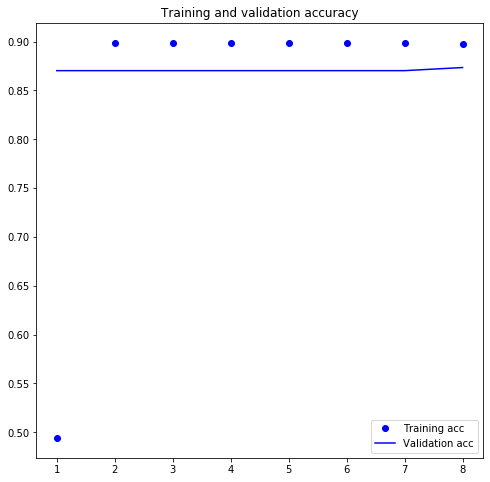

In [26]:
acc = history.history['crf_viterbi_accuracy']
val_acc = history.history['val_crf_viterbi_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize = (8, 8))
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

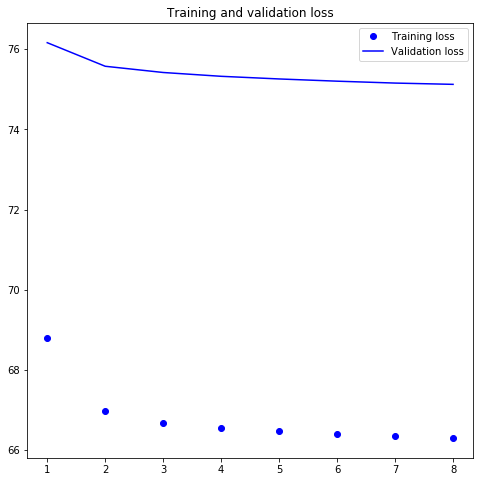

In [27]:
plt.figure(figsize = (8, 8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [28]:
# Evaluation
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)

In [29]:
# Convert the index to tag
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true] 

In [30]:
print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred)))

F1-score is : 67.1%


In [31]:
report = flat_classification_report(y_pred=y_pred, y_true=y_test_true)
print(report)

              precision    recall  f1-score   support

         AGE       0.00      0.00      0.00         2
       B-AGE       0.00      0.00      0.00         1
         B-D       0.00      0.00      0.00        14
         B-N       0.00      0.00      0.00         5
         B-S       0.00      0.00      0.00         3
           D       0.00      0.00      0.00         4
       E-AGE       0.00      0.00      0.00         2
         E-D       0.00      0.00      0.00         5
         E-N       0.00      0.00      0.00         3
         E-S       0.00      0.00      0.00         2
        GEND       0.00      0.00      0.00        12
         I-D       0.00      0.00      0.00        10
         I-N       0.00      0.00      0.00         2
         I-S       0.00      0.00      0.00         2
           M       0.00      0.00      0.00         8
           O       0.89      1.00      0.94      1787
       O-AGE       0.00      0.00      0.00         6
         O-D       0.00    